In [1]:
from sklearn.model_selection import train_test_split
import shutil
from pathlib import Path
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model, load_model 
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from tensorflow.keras.applications.efficientnet import preprocess_input


In [10]:
Base_dir = Path.cwd()                  
Dataset_dir = Base_dir / "dataset" / "processed"  
Train_dir = Dataset_dir / "train"

print("Train path:", Train_dir)
print("Exists:", Train_dir.exists())

Train path: c:\Projects\Car_Recognition\notebooks\dataset\processed\train
Exists: True


In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,  
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2
)


train_gen = train_datagen.flow_from_directory(
    Train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"
)

val_gen = train_datagen.flow_from_directory(
    Train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"
)


Found 9082 images belonging to 356 classes.
Found 2138 images belonging to 356 classes.


In [4]:
print("Classes detected:", train_gen.num_classes)
print("Example mapping:", list(train_gen.class_indices.items())[:5])


Classes detected: 356
Example mapping: [('AM General Hummer SUV 2000', 0), ('Acura Integra Type R 2001', 1), ('Acura RL Sedan 2012', 2), ('Acura TL Sedan 2012', 3), ('Acura TL Type-S 2008', 4)]


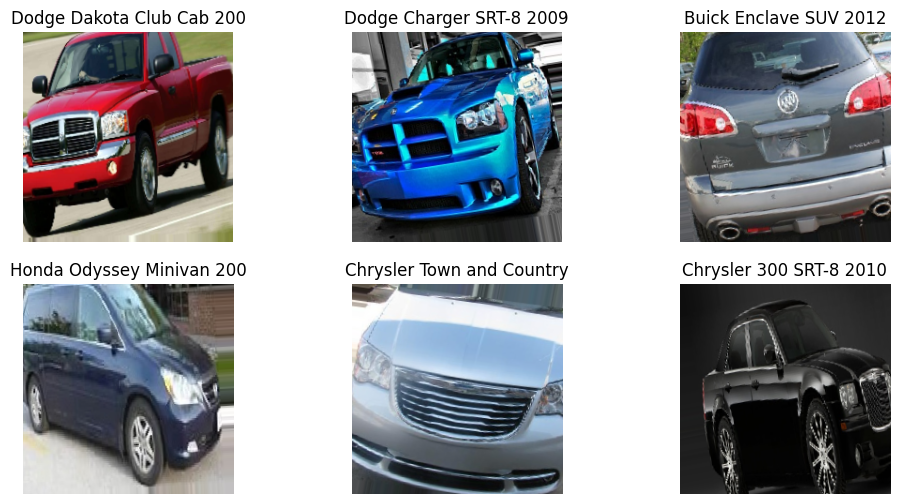

In [6]:
x_batch, y_batch = next(train_gen)
plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow((x_batch[i] - x_batch[i].min()) / (x_batch[i].max() - x_batch[i].min()))
    label_idx = y_batch[i].argmax()
    label_name = list(train_gen.class_indices.keys())[label_idx]
    plt.title(label_name[:25])
    plt.axis("off")
plt.show()

In [13]:
BASE_DIR = Path.cwd().parent
Prev_Model_path = BASE_DIR/"models"/"car_model_efficientnet_V2-2.keras"

num_classes = train_gen.num_classes 

if Prev_Model_path.exists():
    print("Loading existing model")
    model = load_model(Prev_Model_path)

    if model.output_shape[-1] != num_classes:
        print("Adapting Classifier")

        x = model.layers[-2].output 
        new_output = Dense(num_classes, activation="softmax")(x)
        model = Model(model.input, new_output)

else:
    print("Building new model from Imagenet weights")

    base_model = EfficientNetB0(
        weights='imagenet',
        include_top=False,
        input_shape=(224,224,3)
    )

    for layer in base_model.layers:
        layer.trainable = False

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=outputs)


model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=["accuracy"]
)

model.summary()


Loading existing model
Adapting Classifier


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,505,607 (17.19 MB)

 Trainable params: 2,982,900 (11.38 MB)

 Non-trainable params: 1,522,707 (5.81 MB)

In [14]:
EPOCHS = 7

history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS
)

Epoch 1/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 512s 2s/step - accuracy: 0.0317 - loss: 5.5111 - val_accuracy: 0.1118 - val_loss: 4.6993
Epoch 2/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 471s 2s/step - accuracy: 0.1702 - loss: 4.3446 - val_accuracy: 0.2741 - val_loss: 3.7056
Epoch 3/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 476s 2s/step - accuracy: 0.3199 - loss: 3.5177 - val_accuracy: 0.3681 - val_loss: 3.1361
Epoch 4/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 477s 2s/step - accuracy: 0.4209 - loss: 2.9698 - val_accuracy: 0.4425 - val_loss: 2.7419
Epoch 5/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 472s 2s/step - accuracy: 0.4987 - loss: 2.5807 - val_accuracy: 0.4981 - val_loss: 2.4622
Epoch 6/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 514s 2s/step - accuracy: 0.5567 - loss: 2.2943 - val_accuracy: 0.5384 - val_loss: 2.2675
Epoch 7/7
284/284 ━━━━━━━━━━━━━━━━━━━━ 519s 2s/step - accuracy: 0.6147 - loss: 2.0326 - val_accuracy: 0.5664 - val_loss: 2.0671


In [16]:
for layer in model.layers[-50:]:
    layer.trainable = True

print("Trainable layers:", sum(l.trainable for l in model.layers))

model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

EPOCHS_FINE = 3
history_fine = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS_FINE
)

Trainable layers: 54
Epoch 1/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 547s 2s/step - accuracy: 0.6566 - loss: 1.8557 - val_accuracy: 0.5720 - val_loss: 2.0293
Epoch 2/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.6632 - loss: 1.8242 - val_accuracy: 0.5786 - val_loss: 2.0011
Epoch 3/3
284/284 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - accuracy: 0.6640 - loss: 1.7994 - val_accuracy: 0.5716 - val_loss: 1.9804


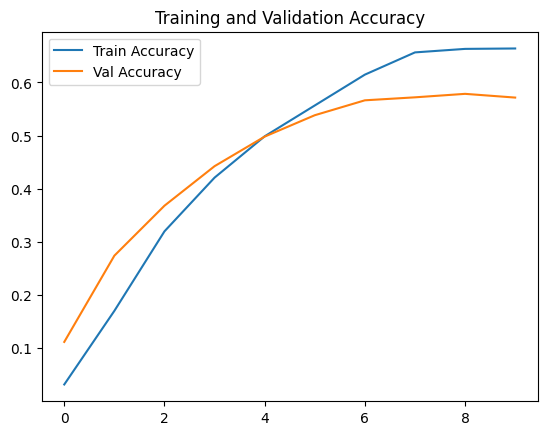

In [17]:
plt.plot(history.history['accuracy'] + history_fine.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + history_fine.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title("Training and Validation Accuracy")
plt.show()


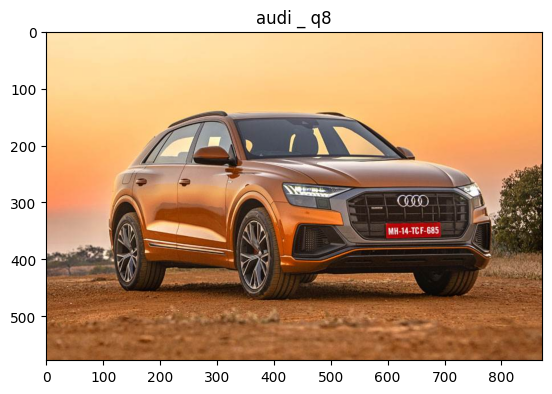

In [18]:
import cv2
import matplotlib.pyplot as plt
import random
import os

cls = random.choice(os.listdir(Train_dir))
img_name = random.choice(os.listdir(Train_dir / cls))
img = cv2.imread(str(Train_dir / cls / img_name))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title(cls)
plt.show()


In [19]:
for root, dirs, files in os.walk(Train_dir):
    print(root, len(files))
    break


c:\Projects\Car_Recognition\notebooks\dataset\processed\train 0


In [20]:
print(train_gen.class_indices)


{'AM General Hummer SUV 2000': 0, 'Acura Integra Type R 2001': 1, 'Acura RL Sedan 2012': 2, 'Acura TL Sedan 2012': 3, 'Acura TL Type-S 2008': 4, 'Acura TSX Sedan 2012': 5, 'Acura ZDX Hatchback 2012': 6, 'Aston Martin V8 Vantage Convertible 2012': 7, 'Aston Martin V8 Vantage Coupe 2012': 8, 'Aston Martin Virage Convertible 2012': 9, 'Aston Martin Virage Coupe 2012': 10, 'Audi 100 Sedan 1994': 11, 'Audi 100 Wagon 1994': 12, 'Audi A5 Coupe 2012': 13, 'Audi R8 Coupe 2012': 14, 'Audi RS 4 Convertible 2008': 15, 'Audi S4 Sedan 2007': 16, 'Audi S4 Sedan 2012': 17, 'Audi S5 Convertible 2012': 18, 'Audi S5 Coupe 2012': 19, 'Audi S6 Sedan 2011': 20, 'Audi TT Hatchback 2011': 21, 'Audi TT RS Coupe 2012': 22, 'Audi TTS Coupe 2012': 23, 'Audi V8 Sedan 1994': 24, 'BMW 1 Series Convertible 2012': 25, 'BMW 1 Series Coupe 2012': 26, 'BMW 3 Series Sedan 2012': 27, 'BMW 3 Series Wagon 2012': 28, 'BMW 6 Series Convertible 2007': 29, 'BMW ActiveHybrid 5 Sedan 2012': 30, 'BMW M3 Coupe 2012': 31, 'BMW M5 Sed

In [21]:
Mod_base_dir = Path.cwd().parent
Model_path = Mod_base_dir/"models"

Model_path.mkdir(exist_ok=True)

In [23]:

VERSION = "V2.3"

save_path = Model_path / f"car_model_efficientnet_{VERSION}.keras"
model.save(save_path)

print("✅ Model saved at:", save_path)


✅ Model saved at: c:\Projects\Car_Recognition\models\car_model_efficientnet_V2.3.keras


In [24]:


MODELS_DIR = BASE_DIR / "models"
MODELS_DIR.mkdir(exist_ok=True)

class_names = list(train_gen.class_indices.keys())

class_names_path = MODELS_DIR / "class_names.txt"

print("Saving to:", class_names_path.resolve())

with open(class_names_path, "w") as f:
    for name in class_names:
        f.write(name + "\n")

print("✅ class_names.txt saved with", len(class_names), "classes")

Saving to: C:\Projects\Car_Recognition\models\class_names.txt
✅ class_names.txt saved with 356 classes
